In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier





In [2]:
data=pd.read_csv("improved_disease_dataset.csv")
encoder=LabelEncoder()
data["disease"]=encoder.fit_transform(data["disease"])

In [3]:
x=data.drop("disease",axis=1)

In [4]:
y=data["disease"]

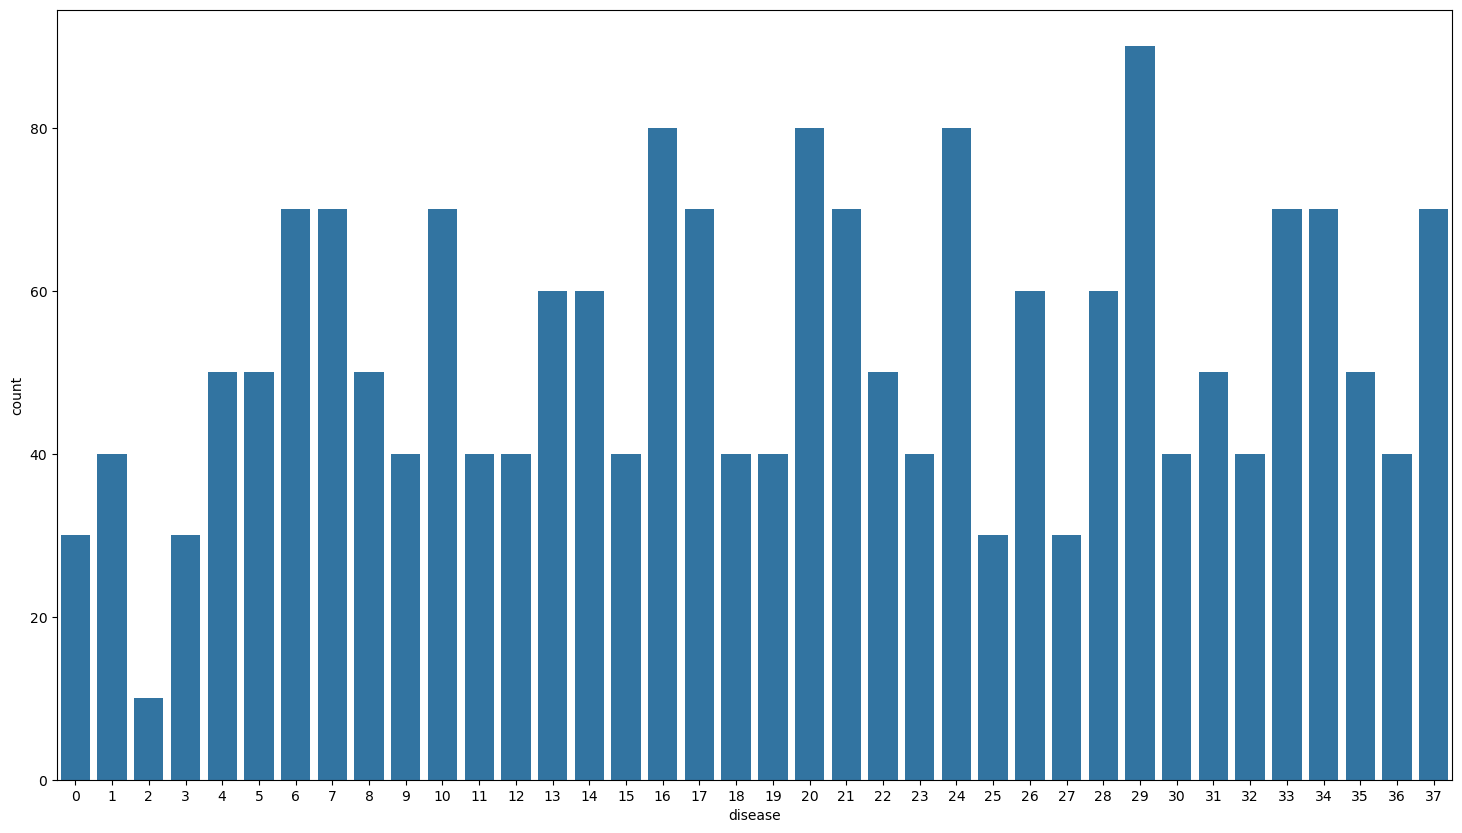

In [5]:
plt.figure(figsize=(18,10))
sns.countplot(x=y)
plt.show()

In [6]:
ros=RandomOverSampler(random_state=42)
x_resampled,y_resampled=ros.fit_resample(x,y)
print("Resampled Class Distribution:\n", pd.Series(y_resampled).value_counts())


Resampled Class Distribution:
 disease
29    90
11    90
4     90
18    90
23    90
1     90
12    90
30    90
32    90
9     90
20    90
36    90
15    90
19    90
27    90
3     90
25    90
0     90
5     90
22    90
35    90
31    90
16    90
24    90
7     90
17    90
34    90
10    90
37    90
6     90
33    90
21    90
26    90
13    90
28    90
14    90
8     90
2     90
Name: count, dtype: int64


In [102]:
if 'gender' in x_resampled.columns:
    le = LabelEncoder()
    x_resampled['gender'] = le.fit_transform(x_resampled['gender'])

x_resampled = x_resampled.fillna(0)

if len(y_resampled.shape) > 1:
    y_resampled = y_resampled.values.ravel()

models = {
    "SVM":SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

cv_scoring = 'accuracy'  
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    try:
        scores = cross_val_score(
            model,
            x_resampled,
            y_resampled,
            cv=stratified_kfold,
            scoring=cv_scoring,
            n_jobs=-1,
            error_score='raise' 
        )
        print("=" * 50)
        print(f"Model: {model_name}")
        print(f"Scores: {scores}")
        print(f"Mean Accuracy: {scores.mean():.4f}")
    except Exception as e:
        print("=" * 50)
        print(f"Model: {model_name} failed with error:")
        print(e)

Model: SVM
Scores: [0.51315789 0.51169591 0.49707602 0.48245614 0.49561404]
Mean Accuracy: 0.5000
Model: Decision Tree
Scores: [0.5497076  0.54385965 0.53508772 0.53654971 0.52631579]
Mean Accuracy: 0.5383
Model: Random Forest
Scores: [0.5628655  0.54093567 0.53654971 0.5380117  0.5380117 ]
Mean Accuracy: 0.5433


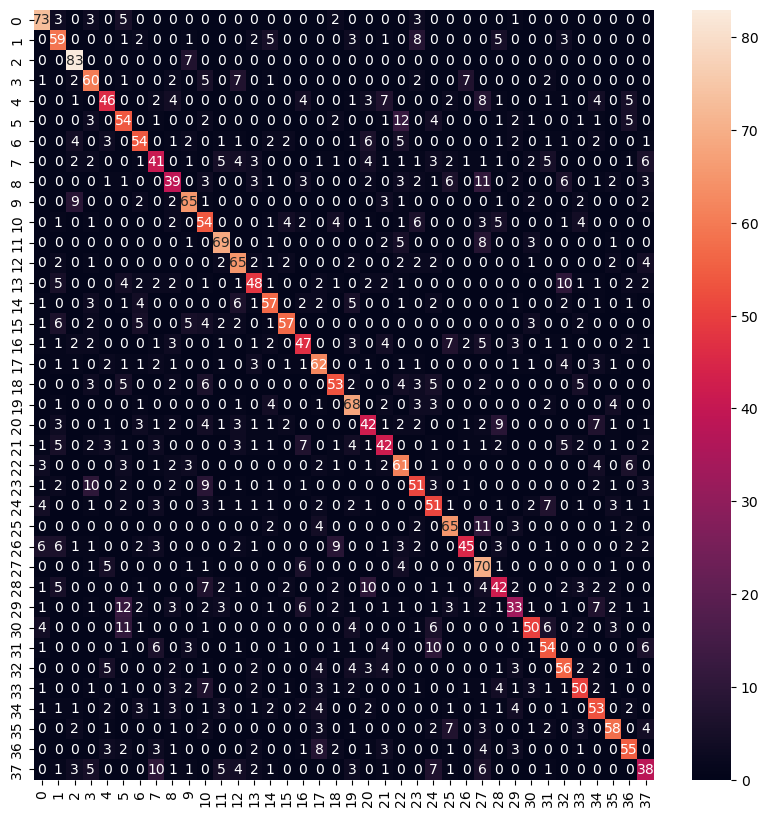

In [104]:
svm_model=SVC()
svm_model.fit(x_resampled,y_resampled)
svm_pred=svm_model.predict(x_resampled)

svm_matrix_svm=confusion_matrix(y_resampled,svm_pred)

plt.figure(figsize=(10,10))
sns.heatmap(svm_matrix_svm,annot=True,fmt="d")
plt.show()

In [9]:
print(f"SVM Accuracy: {accuracy_score(y_resampled, svm_pred) * 100:.2f}%")


SVM Accuracy: 60.53%


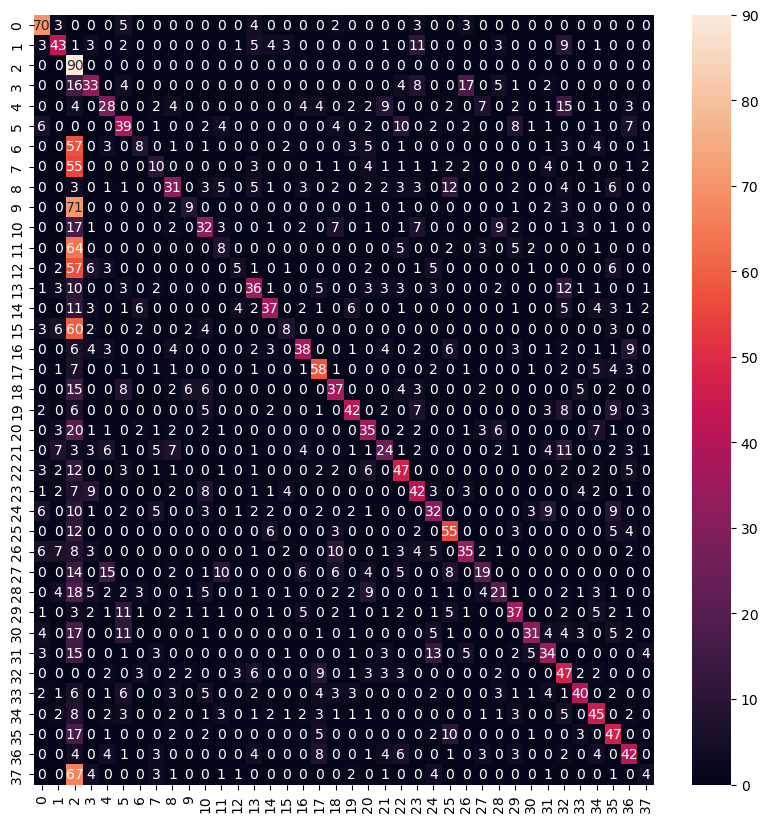

In [10]:
nb_model=GaussianNB()
nb_model.fit(x_resampled,y_resampled)
nb_model_pred=nb_model.predict(x_resampled)
cf_matix_nb=confusion_matrix(y_resampled,nb_model_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matix_nb,annot=True,fmt="d")
plt.show()

In [11]:
print(f"Naive Bayes Accuracy: {accuracy_score(y_resampled, nb_model_pred) * 100:.2f}%")

Naive Bayes Accuracy: 37.98%


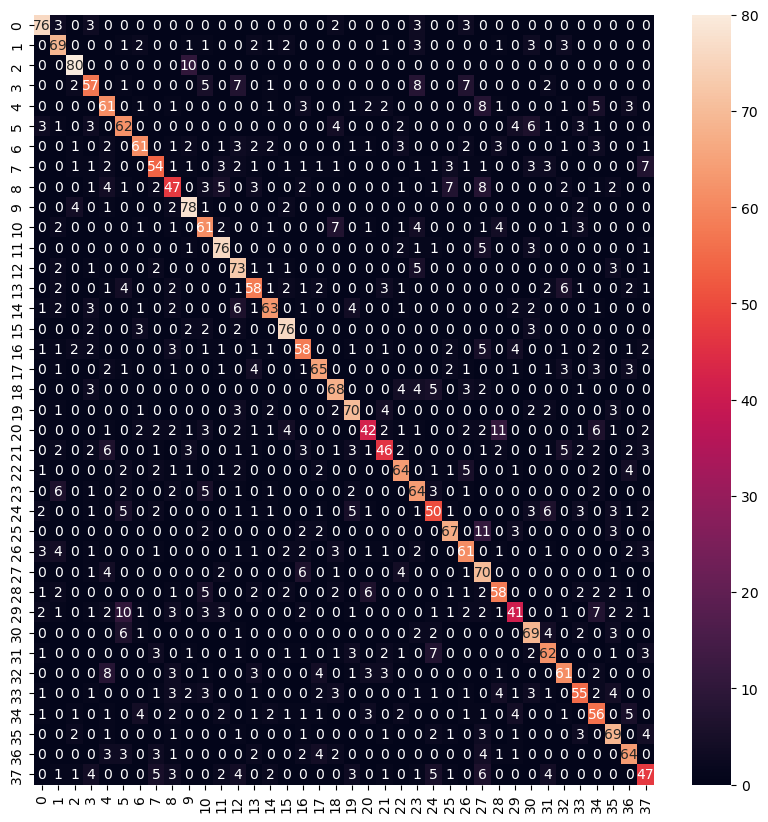

In [12]:
rfc=RandomForestClassifier()
rfc.fit(x_resampled,y_resampled)
rfc_predict=rfc.predict(x_resampled)
conf_matrix=confusion_matrix(y_resampled,rfc_predict)
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix,annot=True,fmt="d")
plt.show()


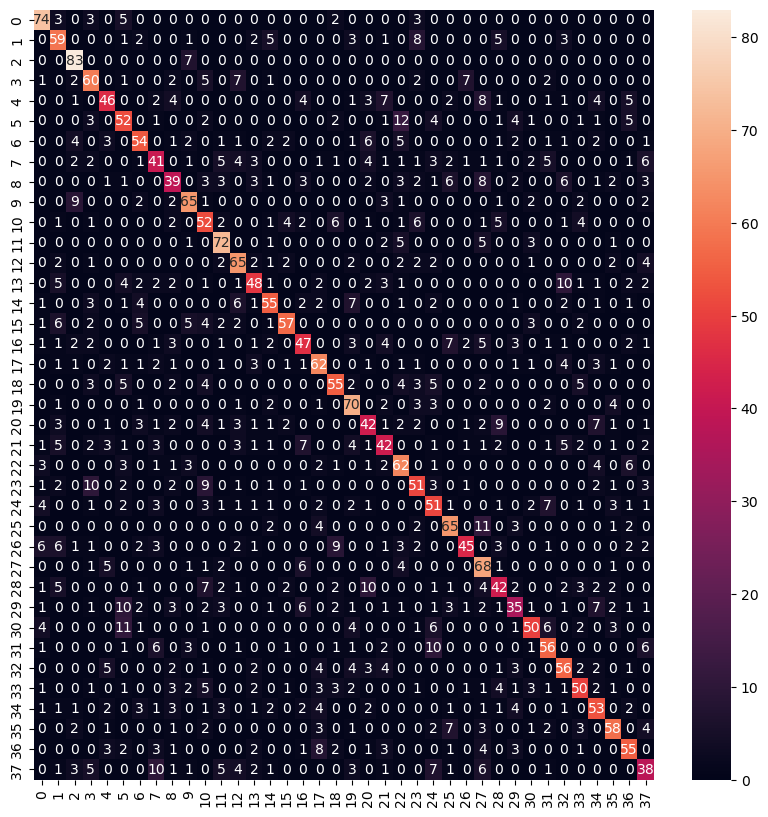

In [28]:
from statistics import mode
final_predicts=[mode([i,j,k]) for i,j,k in zip(svm_pred,nb_model_pred,rfc_predict)]
conf_matrix=confusion_matrix(y_resampled,final_predicts)
plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix,annot=True,fmt="d")
plt.show()

In [32]:
print(f"Combined Model Accuracy: {accuracy_score(y_resampled, final_predicts) * 100:.2f}%")

Combined Model Accuracy: 60.67%


In [108]:
symptoms = x.columns.values
symptom_index = {symptom: idx for idx, symptom in enumerate(symptoms)}

def predict_disease(input_symptoms):
    input_symptoms = input_symptoms.split(",")
    input_data = [0] * len(symptom_index)
    
    for symptom in input_symptoms:
        if symptom in symptom_index:
            input_data[symptom_index[symptom]] = 1
    
    input_data = np.array(input_data).reshape(1, -1)

    rf_pred = encoder.classes_[rfc.predict(input_data)[0]]
    nb_pred = encoder.classes_[nb_model.predict(input_data)[0]]
    svm_pred = encoder.classes_[svm_model.predict(input_data)[0]]

    final_pred = mode([rf_pred, nb_pred, svm_pred])
    
    return {
        "Random Forest Prediction": rf_pred,
        "Naive Bayes Prediction": nb_pred,
        "SVM Prediction": svm_pred,
        "Final Prediction": final_pred
    }

input_symptoms=str(input("Enter your symptoms:"))
print(predict_disease(input_symptoms))

Enter your symptoms: "Vomiting,Abdominal Pain,Fatigue"


{'Random Forest Prediction': 'Heart attack', 'Naive Bayes Prediction': 'Urinary tract infection', 'SVM Prediction': 'Impetigo', 'Final Prediction': 'Heart attack'}


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [106]:
print(y.value_counts())

disease
29    90
16    80
24    80
20    80
37    70
21    70
33    70
6     70
10    70
34    70
17    70
7     70
26    60
13    60
28    60
14    60
4     50
5     50
22    50
35    50
8     50
31    50
32    40
19    40
15    40
36    40
9     40
11    40
30    40
12    40
1     40
23    40
18    40
27    30
3     30
25    30
0     30
2     10
Name: count, dtype: int64
